In [9]:
include("main.jl")

"FP"

In [24]:
@inbounds function muts_by_sel_nonsel(ms1,ms2,s_sel_coef,h_domin_coef,n_loci,sel_loci=[])
    len = length(ms1)
    muts1s = 0
    muts2s = 0
    muts3s = 0
    muts1ns = 0
    muts2ns = 0
    muts3ns = 0
    fits = []
    
    for i in 1:len
        muts_AA_sel = 0
        muts_Aa_sel = 0
        muts_AA_nonsel = 0
        muts_Aa_nonsel = 0
        new_fitness = 1.0

        for j in 1:n_loci
            if ms1[i][j]==true && ms2[i][j]==true
                if j in sel_loci
                    muts_AA_sel += 1
                    new_fitness *= 1 - s_sel_coef
                else
                    muts_AA_nonsel += 1
                end

            elseif ms1[i][j]==true || ms2[i][j]==true
                if j in sel_loci
                    muts_Aa_sel += 1
                    new_fitness *= 1 - h_domin_coef * s_sel_coef
                else
                    muts_Aa_nonsel += 1
                end
            end
        end

        push!(fits,new_fitness)
        muts1s += muts_AA_sel
        muts2s += muts_Aa_sel
        muts1ns += muts_AA_nonsel
        muts2ns += muts_Aa_nonsel
        muts3s = length(sel_loci) - muts_AA_sel - muts_Aa_sel
        muts3ns = n_loci - length(sel_loci) - muts_AA_nonsel - muts_Aa_nonsel
    end

    muts1s /= len
    muts2s /= len
    muts3s /= len
    muts1ns /= len
    muts2ns /= len
    muts3ns /= len
    return muts1s,muts2s,muts3s,muts1ns,muts2ns,muts3ns,fits
end

@inbounds function mutate(ms1,ms2,mut_rate,n_loci)
    get_mutation_random = rand(Poisson(mut_rate))
    @fastmath @inbounds for _ in 1:get_mutation_random
        pos_alter = sample(1:n_loci)

        if rand(1:2)==1
            ms1[pos_alter] = true
        else
            ms2[pos_alter] = true
        end
    end
end

@inbounds function crossover(ms1,ms2,n_loci)
    for j in 1:n_loci
        lr = rand(1:2)
        ms1[j] = lr==1 ? ms1[j] : ms2[j]
    end
end

@inbounds function mate(ind1,ind2,n_loci)
    new_loci = vcat(ind1[1:n_loci],ind2[1:n_loci])
    return new_loci
end

@inbounds function build_next_gen(pnt_wld_ms1,pnt_wld_ms2,pnt_wld_stats,pnt_meanf_wld=NaN,pnt_pops_wld=NaN,pnt_muts_AAsel_wld=NaN,pnt_muts_Aasel_wld=NaN,
    pnt_muts_aasel_wld=NaN,pnt_muts_AAnonsel_wld=NaN,pnt_muts_Aanonsel_wld=NaN,pnt_muts_aanonsel_wld=NaN;
    x_max_migr=NaN,y_max_migr=NaN,migr_mode=0,x_bottleneck=NaN)

    # Determine the number of offspring for each deme
    next_gen_pops = zeros(Int16,pnt_wld_stats["x_max"],pnt_wld_stats["y_max"])
    next_gen_posits = []
    fill!(next_gen_pops,-1)
    for x in 1:pnt_wld_stats["x_max"],y in 1:pnt_wld_stats["y_max"]
        if isassigned(pnt_wld_ms1,x,y) && length(pnt_wld_ms1[x,y])>0
            n_ppl_at_deme = length(pnt_wld_ms1[x,y])
            expected_offspring = n_ppl_at_deme * (pnt_wld_stats["r_prolif_rate"]/(1 + (n_ppl_at_deme*(pnt_wld_stats["r_prolif_rate"]-1))/pnt_wld_stats["k_capacity"]))
            next_gen_pops[x,y] =  rand(Poisson(expected_offspring))
            if next_gen_pops[x,y]>0
                push!(next_gen_posits,[x,y])
            end
        end
    end
    
    # Define the habitat (world) and the data arrays in the next generation
    wld_ms1_next = Array{Array{Array{Bool}}}(undef,pnt_wld_stats["x_max"],pnt_wld_stats["y_max"])
    wld_ms2_next = Array{Array{Array{Bool}}}(undef,pnt_wld_stats["x_max"],pnt_wld_stats["y_max"])
    mean_fitn_next = NaN
    pops_next = NaN
    muts_AAsel_next = NaN
    muts_Aasel_next = NaN
    muts_aasel_next = NaN
    muts_AAnonsel_next = NaN
    muts_Aanonsel_next = NaN
    muts_aanonsel_next = NaN
    all_birth_count = 0

    # Fill the next generation habitat
    meanf_out = false
    pops_out = false
    sel_out = false
    nonsel_out = false
    if pnt_meanf_wld isa Array{Float32, 3}
        meanf_out = true
        mean_fitn_next = Array{Float32}(undef,pnt_wld_stats["x_max"],pnt_wld_stats["y_max"])
        fill!(mean_fitn_next,-1)
    end
    if pnt_pops_wld isa Array{Int32, 3}
        pops_out = true
        pops_next = zeros(Int32,pnt_wld_stats["x_max"],pnt_wld_stats["y_max"])
    end
    if (pnt_muts_AAsel_wld isa Array{Float32, 3}) && (pnt_muts_Aasel_wld isa Array{Float32, 3}) && (pnt_muts_aasel_wld isa Array{Float32, 3})
        sel_out = true
        muts_AAsel_next = zeros(Float32,pnt_wld_stats["x_max"],pnt_wld_stats["y_max"])
        muts_Aasel_next = zeros(Float32,pnt_wld_stats["x_max"],pnt_wld_stats["y_max"])
        muts_aasel_next = zeros(Float32,pnt_wld_stats["x_max"],pnt_wld_stats["y_max"])
    end
    if (pnt_muts_AAnonsel_wld isa Array{Float32, 3}) && (pnt_muts_Aanonsel_wld isa Array{Float32, 3}) && (pnt_muts_aanonsel_wld isa Array{Float32, 3})
        nonsel_out = true
        muts_AAnonsel_next = zeros(Float32,pnt_wld_stats["x_max"],pnt_wld_stats["y_max"])
        muts_Aanonsel_next = zeros(Float32,pnt_wld_stats["x_max"],pnt_wld_stats["y_max"])
        muts_aanonsel_next = zeros(Float32,pnt_wld_stats["x_max"],pnt_wld_stats["y_max"])
    end
    

    for deme in next_gen_posits
        ms1_at_pos = pnt_wld_ms1[deme...]
        ms2_at_pos = pnt_wld_ms2[deme...]

        fitns = []
        cnt_res_AAsel,cnt_res_Aasel,cnt_res_aasel,cnt_res_AAnonsel,cnt_res_Aanonsel,cnt_res_aanonsel,fitns =
            muts_by_sel_nonsel(ms1_at_pos,ms2_at_pos,pnt_wld_stats["s_sel_coef"],pnt_wld_stats["h_domin_coef"],pnt_wld_stats["n_loci"],pnt_wld_stats["sel_loci"])
        
        sum_fitn = sum(fitns)
        fitns /= sum_fitn

        if meanf_out
            mean_fitn_next[deme...] = mean(fitns)
        end
        if sel_out
            muts_AAsel_next[deme...] = cnt_res_AAsel
            muts_Aasel_next[deme...] = cnt_res_Aasel
            muts_aasel_next[deme...] = cnt_res_aasel
        end
        if nonsel_out
            muts_AAnonsel_next[deme...] = cnt_res_AAnonsel
            muts_Aanonsel_next[deme...] = cnt_res_Aanonsel
            muts_aanonsel_next[deme...] = cnt_res_aanonsel
        end

        next_generation_size = next_gen_pops[deme...]
        
        if next_generation_size > 0
            birth_count = 0
            for _ in 1:next_generation_size
                mom_ms1 = wsample(ms1_at_pos,fitns)
                mom_ms2 = wsample(ms2_at_pos,fitns)
                dad_ms1 = wsample(ms1_at_pos,fitns)
                dad_ms2 = wsample(ms2_at_pos,fitns)

                gamete_mom_ms1 = copy(mom_ms1)
                gamete_dad_ms1 = copy(dad_ms1)
                gamete_mom_ms2 = copy(mom_ms2)
                gamete_dad_ms2 = copy(dad_ms2)

                crossover(gamete_mom_ms1,gamete_mom_ms2,pnt_wld_stats["n_loci"])
                crossover(gamete_dad_ms1,gamete_dad_ms2,pnt_wld_stats["n_loci"])
                mutate(gamete_mom_ms1,gamete_mom_ms2,pnt_wld_stats["mut_rate"],pnt_wld_stats["n_loci"])
                mutate(gamete_dad_ms1,gamete_dad_ms2,pnt_wld_stats["mut_rate"],pnt_wld_stats["n_loci"])

                migr_res = rand()

                if migr_mode == 0
                    p_lat = 1
                    p_diag = 0
                elseif migr_mode == 1
                    p_lat = 2/pi
                    p_diag = 1/pi
                elseif migr_mode == 2
                    p_lat = 4/3/pi
                    p_diag = 1/3/pi
                elseif migr_mode == 3
                    p_lat = 0.4244132
                    p_diag = 0.21221
                elseif migr_mode == 4
                    p_lat = 1/2
                    p_diag = 1/2
                elseif migr_mode == 5
                    p_lat = 2/3
                    p_diag = 1/3
                end

                move_x = 0
                move_y = 0
                if migr_res < p_lat+p_diag && rand()<pnt_wld_stats["migr_rate"]
                    if migr_res < p_lat
                        dir = sample(MIGR_DIRS_4)
                    elseif migr_res < p_lat+p_diag
                        dir = sample(MIGR_DIRS_8)
                    end
                    if !isnan(x_bottleneck) && (deme[1]+move_x==x_bottleneck && deme[2]+move_y!=ceil(pnt_wld_stats["y_max"]/2)) # bottleneck barrier check
                        move_x = 0
                        move_y = 0
                    else
                        if deme[1]+move_x > x_max_migr || deme[1]+move_x < 1 # burn-in area check
                            move_x = 0
                            #move_x = -move_x
                        end
                        if deme[2]+move_y > pnt_wld_stats["y_max"] || deme[2]+move_y < 1
                            move_y = 0
                            #move_y = -move_y
                        end
                    end
                end

                if !isassigned(wld_ms1_next,deme[1]+move_x,deme[2]+move_y)
                    wld_ms1_next[deme[1]+move_x,deme[2]+move_y] = []
                    wld_ms2_next[deme[1]+move_x,deme[2]+move_y] = []
                end
                push!(wld_ms1_next[deme[1]+move_x,deme[2]+move_y],gamete_mom_ms1)
                push!(wld_ms2_next[deme[1]+move_x,deme[2]+move_y],gamete_dad_ms2)

                birth_count += 1
                all_birth_count += 1
            end
            
            if pops_out
                pops_next[deme...] = birth_count
            end
        end
    end
    
    pnt_wld_ms1 = wld_ms1_next
    pnt_wld_ms2 = wld_ms2_next
    return mean_fitn_next, pops_next, muts_AAsel_next, muts_Aasel_next, muts_aasel_next, muts_AAnonsel_next, muts_Aanonsel_next, muts_aanonsel_next
end

function create_empty_world(x_max=DEF_X_MAX,y_max=DEF_Y_MAX;k_capacity=DEF_K_CAPACITY,r_prolif_rate=DEF_R_PROLIF_RATE,n_loci=DEF_N_LOCI,n_sel_loci=DEF_N_SEL_LOCI,
    mut_rate=DEF_MUT_RATE,migr_rate=DEF_MIGR_RATE,migr_dirs=DEF_MIGR_DIRS,s_sel_coef=DEF_S_SEL_COEF,h_domin_coef=DEF_H_DOMIN_COEF,prop_of_del_muts=DEF_PROP_OF_DEL_MUTS)

    wld_ms1 = Array{Array{Array{Bool}}}(undef,x_max,y_max) # array of left (in a pair) monosomes ("ms") of all individuals in space
    wld_ms2 = Array{Array{Array{Bool}}}(undef,x_max,y_max) # array of right (in a pair) monosomes ("ms") of all individuals in space

    wld_stats = Dict(
        "x_max" => x_max,
        "y_max" => y_max,

        "k_capacity" => k_capacity,
        "r_prolif_rate" => r_prolif_rate,
        "n_loci" => n_loci,
        "n_sel_loci" => n_sel_loci,
        "mut_rate" => mut_rate,
        "migr_rate" => migr_rate,
        "migr_dirs" => migr_dirs,
        "s_sel_coef" => s_sel_coef,
        "h_domin_coef" => h_domin_coef,
        "prop_of_del_muts" => prop_of_del_muts,

        "rangeexps" => []
    )

    return wld_ms1,wld_ms2,wld_stats
end

function fill_random_demes(pnt_wld_ms1,pnt_wld_ms2,pnt_wld_stats,x_max_fill,y_max_fill,n_demes_to_fill=DEF_N_DEMES_STARTFILL)

    possible_init_coords = [collect(x) for x in Iterators.product(1:x_max_fill, 1:y_max_fill)]
    init_coords = sample(possible_init_coords,n_demes_to_fill;replace=false)
    pnt_wld_stats["sel_loci"] = randperm(pnt_wld_stats["n_loci"])[1:pnt_wld_stats["n_sel_loci"]]

    for coord in init_coords
        if !isassigned(pnt_wld_ms1,coord...)
            pnt_wld_ms1[coord...] = []
            pnt_wld_ms2[coord...] = []
        end
        for i in 1:pnt_wld_stats["k_capacity"]
            push!(pnt_wld_ms1[coord...],falses(pnt_wld_stats["n_loci"]))
            push!(pnt_wld_ms2[coord...],falses(pnt_wld_stats["n_loci"]))
        end
    end

    pnt_wld_stats["x_startfill"] = x_max_fill
    pnt_wld_stats["y_startfill"] = y_max_fill
    pnt_wld_stats["n_demes_startfill"] = n_demes_to_fill
end

function rangeexp_axial(wld_ms1=NaN,wld_ms2=NaN,wld_stats=NaN,
    n_gens_burnin=DEF_N_GENS_BURNIN,n_gens_exp=DEF_N_GENS_EXP,x_max_burnin=DEF_X_MAX_BURNIN,x_max_exp=DEF_X_MAX_EXP,migr_mode=DEF_MIGR_MODE,data_to_generate=DEF_DATA_TO_GENERATE) # expansion along x model 2

    meanf_wld = NaN
    pops_wld = NaN
    muts_AAsel_wld = NaN
    muts_Aasel_wld = NaN
    muts_aasel_wld = NaN
    muts_AAnonsel_wld = NaN
    muts_Aanonsel_wld = NaN
    muts_aanonsel_wld = NaN

    if !(wld_ms1 isa Array{Float32, 3})
        wld_ms1,wld_ms2,wld_stats = create_empty_world(x_max_exp,DEF_Y_MAX)
        fill_random_demes(wld_ms1,wld_ms2,wld_stats,Int(x_max_exp/10),DEF_Y_MAX)
    end

    if occursin("F", data_to_generate)
        meanf_wld = Array{Float32}(undef, wld_stats["x_max"], wld_stats["y_max"], 0)
    end
    if occursin("P", data_to_generate)
        pops_wld = Array{Int32}(undef, wld_stats["x_max"], wld_stats["y_max"], 0)
    end
    if occursin("MS", data_to_generate)
        muts_AAsel_wld = Array{Float32}(undef, wld_stats["x_max"], wld_stats["y_max"], 0)
        muts_Aasel_wld = Array{Float32}(undef, wld_stats["x_max"], wld_stats["y_max"], 0)
        muts_aasel_wld = Array{Float32}(undef, wld_stats["x_max"], wld_stats["y_max"], 0)
    end
    if occursin("M", data_to_generate)
        muts_AAnonsel_wld = Array{Float32}(undef, wld_stats["x_max"], wld_stats["y_max"], 0)
        muts_Aanonsel_wld = Array{Float32}(undef, wld_stats["x_max"], wld_stats["y_max"], 0)
        muts_aanonsel_wld = Array{Float32}(undef, wld_stats["x_max"], wld_stats["y_max"], 0)
    end

    n_gens_total = n_gens_burnin+n_gens_exp
    @inbounds for g in 1:n_gens_total
        if g>n_gens_burnin
            _x_max_used = x_max_burnin
        else
            _x_max_used = x_max_exp
        end
        mean_fitn_next,pops_next,muts_AAsel_next,muts_Aasel_next,muts_aasel_next,muts_AAnonsel_next,
        muts_Aanonsel_next,muts_aanonsel_next = build_next_gen(wld_ms1,wld_ms2,wld_stats,meanf_wld,pops_wld,muts_AAsel_wld,muts_Aasel_wld,muts_aasel_wld,muts_AAnonsel_wld,
        muts_Aanonsel_wld,muts_aanonsel_wld;x_max_migr=_x_max_used,y_max_migr=DEF_Y_MAX,migr_mode=0,x_bottleneck=x_max_burnin+1)
        if occursin("F", data_to_generate)
            meanf_wld = cat(meanf_wld, mean_fitn_next, dims=3)
        end
        if occursin("P", data_to_generate)
            pops_wld = cat(pops_wld, pops_next, dims=3)
        end
        if occursin("MS", data_to_generate)
            muts_AAsel_wld = cat(muts_AAsel_wld, muts_AAsel_next, dims=3)
            muts_Aasel_wld = cat(muts_Aasel_wld, muts_Aasel_next, dims=3)
            muts_aasel_wld = cat(muts_aasel_wld, muts_aasel_next, dims=3)
        end
        if occursin("M", data_to_generate)
            muts_AAnonsel_wld = cat(muts_AAnonsel_wld, muts_AAnonsel_next, dims=3)
            muts_Aanonsel_wld = cat(muts_Aanonsel_wld, muts_Aanonsel_next, dims=3)
            muts_aanonsel_wld = cat(muts_aanonsel_wld, muts_aanonsel_next, dims=3)
        end
    end

    append!(wld_stats["rangeexps"],Dict(
        "x_max_burnin" => x_max_burnin,
        "y_max_burnin" => DEF_Y_MAX,
        "n_gens_burnin" => n_gens_burnin,
        "n_gens_exp" => n_gens_exp,
        "n_gens" => n_gens_total))
    
    return wld_ms1,wld_ms2,wld_stats,meanf_wld,pops_wld,muts_AAsel_wld,muts_Aasel_wld,muts_aasel_wld,muts_AAnonsel_wld,muts_Aanonsel_wld,muts_aanonsel_wld
end

rangeexp_axial (generic function with 10 methods)

In [25]:
rangeexp_axial()[4]

100×20×20 Array{Float32, 3}:
[:, :, 1] =
 -1.0  -1.0  -1.0  -1.0  -1.0   0.05  …  -1.0  -1.0  -1.0  -1.0  -1.0   0.05
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0      -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0      -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0      -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0      -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0      -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0      -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0      -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0      -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
  ⋮                             ⋮     ⋱         ⋮                      
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0      -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0      -1.0  -1.

In [3]:
function modify_array(arr)
    arr = cat(arr, [4, 5, 6], dims=1)
end


original_arr = [1, 2, 3]
modified_arr = modify_array(original_arr)

println(original_arr)  # Prints [1, 2, 3, 4, 5, 6]

[1, 2, 3]


In [156]:
test_stats["rangeexps"]

UndefVarError: UndefVarError: `test_stats` not defined

┌ Info: Saved animation to C:\Users\Hartree\AppData\Local\Temp\jl_05kZI361yZ.gif
└ @ Plots C:\Users\Hartree\.julia\packages\Plots\ju9dp\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\Hartree\\AppData\\Local\\Temp\\jl_05kZI361yZ.gif")
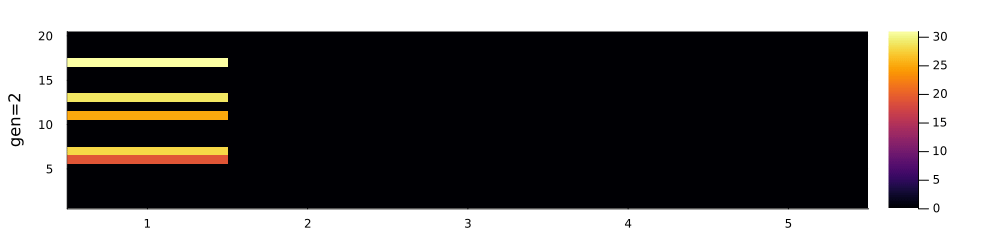

In [27]:
slow_down = 1
gen_start = 1
gen_end = 20

@gif for i=gen_start:(gen_end*slow_down-1)
    gen_no = trunc(Int,i/slow_down)+1
    heatmap(rangeexp_axial()[5][:,:,gen_no]',ylabel="gen=$gen_no",size=(1000,250))
end